# Getting Started with `bw_timex`

This notebook will help you quickly getting started with your time-explicit LCA project. We're keeping it simple here - no deep dives into how things work in the background, no exploring of all the features and options `bw_timex` has. Just a quick walkthrough of the different steps of a `TimexLCA`. Here's a rundown:

<div style="display: flex; justify-content: center; background-color: white; border-radius: 15px; padding: 10px; width: 45%; margin: auto;">
  <img src="data/method.svg" style="border-radius: 15px; width: 100%;">
</div>

In the following sections, we'll walk through the steps 1-4, considering a very simple dummy system.


## Step 1 - Adding temporal information

To get you started with time-explicit LCA, we'll investigate this very simple production system with two "technosphere" nodes A and B and a "biosphere" node representing some CO2 emissions. For the sake of this example, we'll assume that we demand Process A to run exactly once.

```mermaid
flowchart LR
subgraph background[<i>background</i>]
    B(Process B):::bg
end

subgraph foreground[<i>foreground</i>]
    A(Process A):::fg
end

subgraph biosphere[<i>biosphere</i>]
    CO2(CO2):::bio
end

B-->|"3 kg"|A
A-.->|"5 kg"|CO2
B-.->|"11 kg"|CO2

classDef fg color:#222832, fill:#3fb1c5, stroke:none;
classDef bg color:#222832, fill:#3fb1c5, stroke:none;
classDef bio color:#222832, fill:#9c5ffd, stroke:none;
style background fill:none, stroke:none;
style foreground fill:none, stroke:none;
style biosphere fill:none, stroke:none;
```

First, we need to model this production system - so far only "normal" brightway stuff:

In [1]:
import bw2data as bd

bd.projects.set_current("getting_started_with_timex")

bd.Database("biosphere").write(
    {
        ("biosphere", "CO2"): {
            "type": "emission",
            "name": "CO2",
        },
    }
)

bd.Database("background").write(
    {
        ("background", "B"): {
            "name": "B",
            "location": "somewhere",
            "reference product": "B",
            "exchanges": [
                {
                    "amount": 1,
                    "type": "production",
                    "input": ("background", "B"),
                },
                {
                    "amount": 11,
                    "type": "biosphere",
                    "input": ("biosphere", "CO2"),
                },
            ],
        },
    }
)

bd.Database("foreground").write(
    {
        ("foreground", "A"): {
            "name": "A",
            "location": "somewhere",
            "reference product": "A",
            "exchanges": [
                {
                    "amount": 1,
                    "type": "production",
                    "input": ("foreground", "A"),
                },
                {
                    "amount": 3,
                    "type": "technosphere",
                    "input": ("background", "B"),
                },
                {
                    "amount": 5,
                    "type": "biosphere",
                    "input": ("biosphere", "CO2"),
                }
            ],
        },
    }
)

bd.Method(("our", "method")).write(
    [
        (("biosphere", "CO2"), 1),
    ]
)

100%|██████████| 1/1 [00:00<00:00, 6096.37it/s]


Vacuuming database 
Not able to determine geocollections for all datasets. This database is not ready for regionalization.


100%|██████████| 1/1 [00:00<00:00, 24385.49it/s]


Vacuuming database 
Not able to determine geocollections for all datasets. This database is not ready for regionalization.


100%|██████████| 1/1 [00:00<00:00, 23301.69it/s]

Vacuuming database 


Now, if you want to consider time in your LCA, you need to somehow add temporal information. For time-explicit LCA, we consider two kinds of temporal information, that will be discussed in the following.

### Temporal distributions

To determine the timing of the exchanges within the production system, we add the `temporal_distribution` attribute to the respective exchanges. To carry the temporal information, we use the [`TemporalDistribution`](https://docs.brightway.dev/projects/bw-temporalis/en/stable/content/api/bw_temporalis/temporal_distribution/index.html#bw_temporalis.temporal_distribution.TemporalDistribution) class from [`bw_temporalis`](https://github.com/brightway-lca/bw_temporalis). This class is a *container for a series of amount spread over time*, so it tells you what share of an exchange happens at what point in time. So, let's include this information in out production system - visually at first:

```mermaid
flowchart LR
subgraph background[" "]
    B_2020(Process B):::bg
end

subgraph foreground[" "]
    A(Process A):::fg
end

subgraph biosphere[" "]
    CO2(CO2):::b
end

B_2020-->|"amounts: [30%,50%,20%] * 3 kg\n dates:[-2,0,+4]" years|A
A-.->|"amounts: [60%, 40%] * 5 kg\n dates: [0,+1]" years|CO2
B_2020-.->|"amounts: [100%] * 11 kg\n dates:[0]" years|CO2

classDef bg color:#222832, fill:#3fb1c5, stroke:none;
classDef fg color:#222832, fill:#3fb1c5, stroke:none;
classDef b color:#222832, fill:#9c5ffd, stroke:none;
style foreground fill:none, stroke:none;
style background fill:none, stroke:none;
style biosphere fill:none, stroke:none;

```

Now it's time to add this information to our modeled production system in brightway:


In [2]:
import numpy as np
from bw_temporalis import TemporalDistribution
from bw_timex.utils import add_temporal_distribution_to_exchange

# Starting with the exchange between A and B
# First, create a TemporalDistribution with the time information from above
td_b_to_a = TemporalDistribution(
    date=np.array([-2, 0, 4], dtype="timedelta64[Y]"),
    amount=np.array([0.3, 0.5, 0.2]),
)

# Now add the temporal distribution to the corresponding exchange. In 
# principle, you just have to do the following:
# exchange_object["temporal_distribution"] = TemporalDistribution 
# We currently don't have the exchange-object at hand here, but we can 
# use the utility function add_temporal_distribution_to_exchange to help.
add_temporal_distribution_to_exchange(
    temporal_distribution=td_b_to_a, 
    input_code="B", 
    input_database="background",
    output_code="A",
    output_database="foreground"
)

# Now we do the same for our other temporalized exchange between A and CO2
td_a_to_co2 = TemporalDistribution(
    date=np.array([0, 1], dtype="timedelta64[Y]"),
    amount=np.array([0.6, 0.4]),
)

# We actually only have to define enough fields to uniquely identify the 
# exchange here
add_temporal_distribution_to_exchange(
    temporal_distribution=td_a_to_co2, 
    input_code="CO2", 
    output_code="A"
)

### Prospective data

The other kind of temporal data we can add is some prospective information on how our processes change over time. So, for our simple example, let's say our background process B somehow evolves, so that it emitts less CO2 in the future. To make it precise, we assume that the original process we modeled above represents the process state in the year 2020, emitting 11 kg CO2, which reduces to 7 kg CO2 by 2030:

```mermaid
flowchart LR
subgraph background[" "]
    B_2020(Process B \n 2020):::bg
    B_2030(Process B \n 2030):::bg
end

subgraph foreground[" "]
    A(Process A):::fg
end

subgraph biosphere[" "]
    CO2(CO2):::b
end

B_2020-->|"amounts: [30%,50%,20%] * 3 kg\n dates:[-2,0,+4]" years|A
A-.->|"amounts: [60%, 40%] * 5 kg\n dates: [0,+1]" years|CO2
B_2020-.->|"amounts: [100%] * <span style='color:#9c5ffd'><b>11 kg</b></span>\n dates:[0]" years|CO2
B_2030-.->|"amounts: [100%] * <span style='color:#9c5ffd'><b>7 kg</b></span>\n dates:[0]" years|CO2

classDef bg color:#222832, fill:#3fb1c5, stroke:none;
classDef fg color:#222832, fill:#3fb1c5, stroke:none;
classDef b color:#222832, fill:#9c5ffd, stroke:none;
style foreground fill:none, stroke:none;
style background fill:none, stroke:none;
style biosphere fill:none, stroke:none;

```


In [3]:
bd.Database("background_2030").write(
    {
        ("background_2030", "B"): {
            "name": "B",
            "location": "somewhere",
            "reference product": "B",
            "exchanges": [
                {
                    "amount": 1,
                    "type": "production",
                    "input": ("background_2030", "B"),
                },
                {
                    "amount": 7,
                    "type": "biosphere",
                    "input": ("biosphere", "CO2"),
                },
            ],
        },
    }
)

Not able to determine geocollections for all datasets. This database is not ready for regionalization.


100%|██████████| 1/1 [00:00<00:00, 23696.63it/s]

Vacuuming database 


So, as you can see, the prospective processes can reside within your normal brightway databases. To hand them to `bw_timex`, we just need to define a dictionary that maps the prospective database names to the point in time that they represent:

In [4]:
from datetime import datetime

# Note: The foreground does not represent a specific point in time, but should 
# later be dynamically distributed over time
database_date_dict = {
    "background": datetime.strptime("2020", "%Y"),
    "background_2030": datetime.strptime("2030", "%Y"),
    "foreground": "dynamic",
}

> **Note:** You can use whatever data source you want for this prospective data. A nice package from the Brightway cosmos that can help you is [premise](https://premise.readthedocs.io/en/latest/introduction.html).

## Step 2 - Building the process timeline 

With all the temporal information prepared, we can now instantiate our TimexLCA object. This is very similar to a normal Brightway LCA object, but with the additional argument of our `database_date_dict`:

In [5]:
from bw_timex import TimexLCA

tlca = TimexLCA(
    demand={("foreground", "A"): 1},
    method=("our", "method"),
    database_date_dict=database_date_dict,
)

Using our new `tlca` object, we can now build the timeline of processes that leads to our functional unit, "A". If not specified otherwise, it's assumed that the demand occurs in the current year, which is 2024 at the time of writing. Building the timeline is very simple:

In [6]:
tlca.build_timeline()

Starting graph traversal
Calculation count: 1


/Users/timodiepers/Documents/Coding/bw_timex/bw_timex/timex_lca.py:212: UserWarning: No edge filter function provided. Skipping all edges within background databases.
  warnings.warn(


,date_producer,producer_name,date_consumer,consumer_name,amount,interpolation_weights
0,2022-01-01,B,2024-01-01,A,0.9,"{'background': 0.7998905009581166, 'background..."
1,2024-01-01,B,2024-01-01,A,1.5,"{'background': 0.6000547495209416, 'background..."
2,2024-01-01,A,2024-01-01,-1,1.0,None
3,2028-01-01,B,2024-01-01,A,0.6,"{'background': 0.20010949904188335, 'backgroun..."


Calling this directly returned the `tlca.timeline` dataframe. Here we can see which share of which exchange happens at what point in time. Additionally, the "interpolation_weights" already tell us what share of an exchange should come from which database. With this info, we can calculate our time-explicit LCI in the next step.

## Step 3 - Calculating the time-explicit LCI

Calculating the time-explicit LCI from the timeline is very simple, at least from the user perspective:


In [7]:
tlca.lci()

/Users/timodiepers/anaconda3/envs/timex/lib/python3.10/site-packages/bw2calc/lca_base.py:127: SparseEfficiencyWarning: splu converted its input to CSC format
  self.solver = factorized(self.technosphere_matrix)


Under the hood, we re-build the technosphere and biosphere matrices, adding new rows and columns to carry the extra temporal information. More on that in the [Theory Section](https://docs.brightway.dev/projects/bw-timex/en/latest/content/theory.html#modifying-the-matrices) of our docs.

Now that the inventory is calculated, we can characterize it in the next step.

## Step 4 - Impact assessment

To characterize the calculated inventory, we have two options: Static and dynamic life cycle impact assessment (LCIA).

### Static LCIA
If we don't care about the timing of the emissions, we can do static LCIA using the standard characterization factors. To characterize the inventory with the impact assessment method that we initially chose when creating our `TimexLCA` object, we can simply call:

In [8]:
tlca.static_lcia()

and investigate the resulting score like this:

In [9]:
tlca.static_score

32.96019709827539

### Dynamic LCIA

The inventory calculated by a `TimexLCA` retains temporal information. That means that in addition to knowing which process emits what substance, we also know the timing of each emission. This allows for more advanced, dynamic characterization using characterization functions instead of just factors. In `bw_timex`, users can either use their own curstom functions or use some existing ones, e.g., from the package [`dynamic_characterization`](https://dynamic-characterization.readthedocs.io/en/latest/). We'll do the latter here. 

First, we need to define which characterization function we want to apply to which biosphere flow:

In [10]:
from dynamic_characterization.timex import characterize_co2
emission_id = bd.get_activity(("biosphere", "CO2")).id

characterization_function_dict = {
    emission_id: characterize_co2,
}

So, let's characterize our inventory. As a metric we choose radiative forcing, and a time horizon of 100 years:

In [11]:
tlca.dynamic_lcia(
    metric="radiative_forcing",
    time_horizon=100,
    characterization_function_dict=characterization_function_dict,
)

,date,amount,flow,activity
0,2023-01-01 05:49:12,1.512067e-14,364,368
1,2024-01-01 11:38:24,1.419411e-14,364,368
2,2024-12-31 05:49:12,2.322610e-14,364,369
3,2024-12-31 05:49:12,4.941608e-15,364,370
4,2024-12-31 17:27:36,1.343660e-14,364,368
...,...,...,...,...
490,2124-01-01 06:00:00,1.400972e-15,364,370
491,2124-01-01 06:43:12,3.302104e-15,364,371
492,2124-12-31 12:32:24,3.294094e-15,364,371
493,2125-12-31 18:21:36,3.286213e-15,364,371


To visualize what's going on, we can conveniently plot it with:

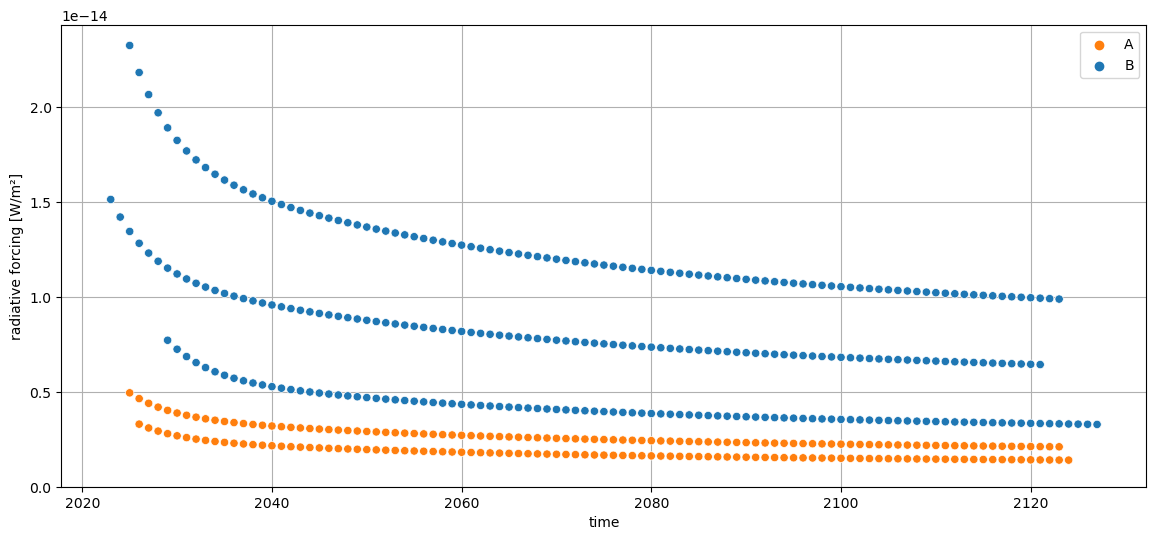

In [12]:
tlca.plot_dynamic_characterized_inventory()

Of course we can also assess the "standard" climate change metric Global Warming Potential (GWP):

In [13]:
tlca.dynamic_lcia(
    metric="GWP",
    time_horizon=100,
    characterization_function_dict=characterization_function_dict,
)

/Users/timodiepers/anaconda3/envs/timex/lib/python3.10/site-packages/dynamic_characterization/dynamic_characterization.py:262: UserWarning: Using bw_timex's default CO2 characterization function for GWP reference.
  warnings.warn(


,date,amount,flow,activity
0,2022-01-01 00:00:00,9.179606,364,368
1,2024-01-01 00:00:00,14.100328,364,369
2,2024-01-01 00:00:00,3.000000,364,370
3,2024-12-31 05:49:12,2.000000,364,370
4,2028-01-01 00:00:00,4.680263,364,371


... and plot it:

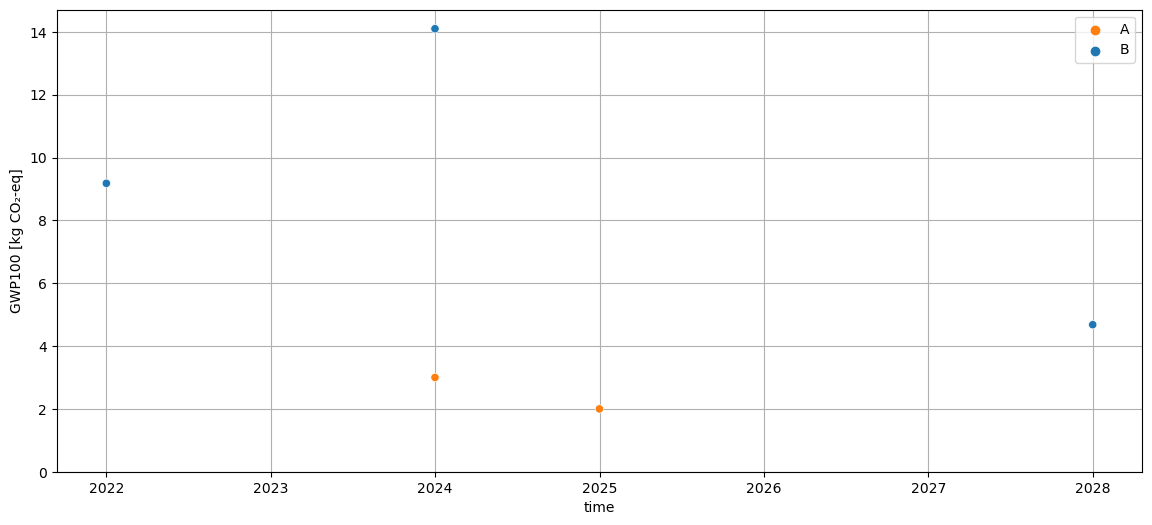

In [14]:
tlca.plot_dynamic_characterized_inventory()

For most of the functions we used here, there are numerous optional arguments and settings you can tweak. We explore some of them in our other [Examples](../examples/index.md), but when in doubt: Our code is pretty well documented, see our [docstrings](../api/index) - so please browse through them as needed ☀️